# Imports

In [ ]:
import joblib
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
    classification_report
)

# Data Loading

In [ ]:
# loaded data
data = joblib.load("data_splits.pkl")

X_train = data["X_train"]
X_val = data["X_val"]
X_test = data["X_test"]
y_train = data["y_train"]
y_val = data["y_val"]
y_test = data["y_test"]

# Model

In [ ]:
class LogisticRegression:
    def __init__(self, lr=0.01, epochs=1000):
        # Initialize learning rate, number of epochs, weights, and bias
        self.lr = lr
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.loss_history = []

    def sigmoid(self, z):
        # Sigmoid activation function
        return 1 / (1 + np.exp(-z))

    def train(self, X, y):
        """Train the logistic regression model."""
        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0

        for epoch in range(self.epochs):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)

            # Compute gradients
            dw = (1 / m) * np.dot(X.T, (y_pred - y))
            db = (1 / m) * np.sum(y_pred - y)

            # Update parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            # Compute and store loss
            epsilon = 1e-15
            y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
            loss = -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
            self.loss_history.append(loss)

    def predict(self, X):
        # Predict class labels (0 or 1)
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(linear_model)
        return (y_pred >= 0.5).astype(int)

    def predict_proba(self, X):
        # Predict probability estimates
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)

In [ ]:
def train_and_evaluate(X_train, y_train, X_val, y_val, lr, epochs):
    # Initialize and train the logistic regression model
    model = LogisticRegression(lr=lr, epochs=epochs)
    model.train(X_train, y_train)

    # Predict on validation data
    y_pred = model.predict(X_val)

    # Calculate accuracy
    acc = accuracy_score(y_val, y_pred)

    return acc, model

# Hyperparameter Tuning

In [ ]:
# Initialize variables to track the best model and its performance
best_model = None
best_accuracy = 0
best_params = {}

# Define ranges of learning rates and epoch values to try
learning_rates = [0.001, 0.01, 0.1]
epoch_options = [500, 1000, 2000]

# Grid search over all combinations of learning rates and epochs
for lr in learning_rates:
    for epochs in epoch_options:
        acc, model = train_and_evaluate(X_train, y_train, X_val, y_val, lr, epochs)
        print(f"lr={lr}, epochs={epochs}, accuracy={acc:.4f}")

        # Update best model if current one is better
        if acc > best_accuracy:
            best_accuracy = acc
            best_model = model
            best_params = {'lr': lr, 'epochs': epochs}

# Display the best hyperparameters and corresponding accuracy
print(f"\nBest Params: {best_params}, Best Accuracy: {best_accuracy:.4f}")

lr=0.001, epochs=500, accuracy=0.8650
lr=0.001, epochs=1000, accuracy=0.8796
lr=0.001, epochs=2000, accuracy=0.8926
lr=0.01, epochs=500, accuracy=0.9016
lr=0.01, epochs=1000, accuracy=0.9135
lr=0.01, epochs=2000, accuracy=0.9303
lr=0.1, epochs=500, accuracy=0.9369
lr=0.1, epochs=1000, accuracy=0.9081
lr=0.1, epochs=2000, accuracy=0.9263

Best Params: {'lr': 0.1, 'epochs': 500}, Best Accuracy: 0.9369


# Training on best parameters

In [ ]:
# Re-train the model using the best hyperparameters on the training data
model = LogisticRegression(lr=best_params['lr'], epochs=best_params['epochs'])
model.train(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate final model accuracy on the test data
acc = accuracy_score(y_test, y_pred)

In [ ]:
print(f"Test accuracy: {acc:.4f}")

Test accuracy: 0.9419


Final Test Accuracy: 94.19%

# Result Evaluation

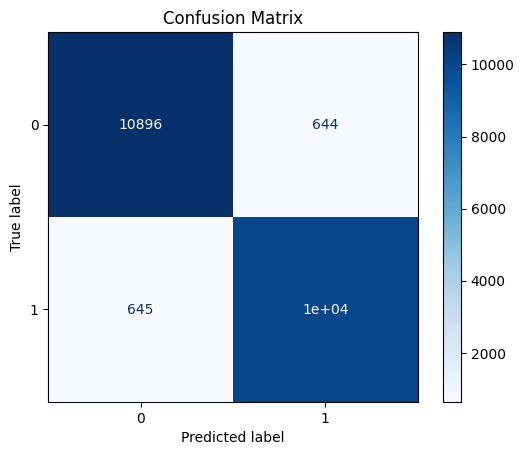

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

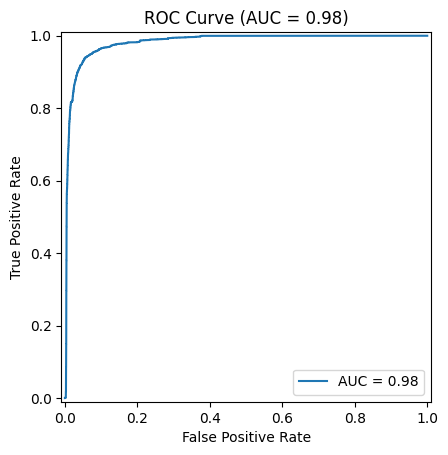

In [ ]:
y_prob = model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title("ROC Curve (AUC = {:.2f})".format(roc_auc))
plt.show()

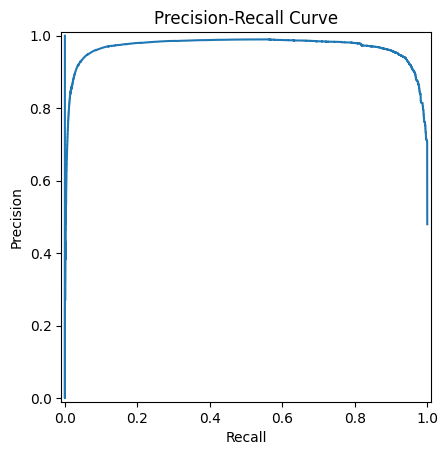

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title("Precision-Recall Curve")
plt.show()

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
0,0.944112,0.944194,0.944153,11540.0000
1,0.939502,0.939414,0.939458,10646.0000
accuracy,0.941900,0.941900,0.941900,0.9419
macro avg,0.941807,0.941804,0.941806,22186.0000
weighted avg,0.941900,0.941900,0.941900,22186.0000
